In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
# from spline import  BSplineActivation, FixedSplineActivation
# from  Kan_Layer import *
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torchmetrics.regression import MeanAbsolutePercentageError, R2Score,MeanSquaredError,MeanAbsoluteError
np.random.seed(142)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import time

In [89]:
# data for Abidjan
Abj_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/data/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
# data for Kigali
Kgl_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks//data/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})

# print(df.info())
# df.describe(),data_.describe()
# df.head(4) 
# Abj_dt
#Rename Columns
col_name_map = {
    "ALLSKY_SFC_SW_DWN": "ASWD",
    "CLRSKY_SFC_SW_DWN":"CSWD","ALLSKY_SFC_LW_DWN":"ALWD","PRECTOTCORR":"PREC"
}
# new_colnames=['datetime', 'ASWD', 'CSWD',
#        'ALWD', 'T2M', 'T2MDEW', 'T2MWET', 'QV2M', 'RH2M',
#        'PREC', 'PS']
# Rename the columns for both datasets
Abj_dt=Abj_dt.set_index("datetime")
Kgl_dt=Kgl_dt.set_index("datetime")
Abj_dt=Abj_dt.rename(columns=col_name_map)
Kgl_dt =Kgl_dt.rename(columns=col_name_map)
# Xy_train
# target_col = Abj_dt.pop("T2M")
# Abj_dt.insert(len(Abj_dt.columns),"T2M", target_col)
# Abj_dt
# target_col = Abj_dt.pop("PREC")
# Abj_dt.insert(len(Abj_dt.columns),"PREC", target_col)
# Abj_dt

/tmp/ipykernel_2722422/1808952058.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Abj_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks/data/Abidjan_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})
/tmp/ipykernel_2722422/1808952058.py:4: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  Kgl_dt = pd.read_csv('/home/akazan/Weather/Deep-Learning-for-Weather-Prediction/notebooks//data/Kigali_data.csv',parse_dates={'datetime': ['YEAR', 'MO','DY']})


In [90]:
dates=Abj_dt.index.astype(str).tolist()
# Abj_dt

In [91]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [5]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class FixedSplineActivation(nn.Module):
    def __init__(self, exponent: float = 1.0, max_exponent: float = 9.0):
        super(FixedSplineActivation, self).__init__()
        self.exponent = torch.tensor(exponent, dtype=torch.float32)
        self.max_exponent = torch.tensor(max_exponent, dtype=torch.float32)
        self.epsilon = torch.finfo(torch.float32).eps
        self.exponent = torch.clamp(self.exponent, -self.max_exponent, self.max_exponent)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        inputs_safe = torch.clamp(inputs, self.epsilon, 1.0)
        return torch.pow(inputs_safe, self.exponent)

    def extra_repr(self) -> str:
        return f'exponent={{self.exponent}}, max_exponent={{self.max_exponent}}'

class PowerSplineActivation(nn.Module):
    def __init__(self, initial_exponent: float = 1.0, epsilon: float = 1e-7, max_exponent: float = 9.0, trainable: bool = True):
        super(PowerSplineActivation, self).__init__()
        self.epsilon = epsilon
        self.max_exponent = torch.tensor(max_exponent, dtype=torch.float32)
        self.trainable = trainable

        self.exponent = nn.Parameter(torch.tensor(initial_exponent, dtype=torch.float32), requires_grad=trainable)
        self.bias = nn.Parameter(torch.zeros(1), requires_grad=trainable)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        clipped_exponent = torch.clamp(self.exponent, -self.max_exponent, self.max_exponent)
        x_safe = torch.clamp(inputs + self.bias, self.epsilon, 1.0)
        return torch.pow(x_safe, clipped_exponent)

    def extra_repr(self) -> str:
        return f'initial_exponent={{self.exponent}}, epsilon={{self.epsilon}}, max_exponent={{self.max_exponent}}, trainable={{self.trainable}}'

class LinspaceInitializer:
    def __init__(self, start: float, stop: float, num: int):
        self.start = start
        self.stop = stop
        self.num = num

    def __call__(self, shape):
        return torch.linspace(self.start, self.stop, self.num).reshape(shape)

    def __repr__(self):
        return f'LinspaceInitializer(start={{self.start}}, stop={{self.stop}}, num={{self.num}})'

class BSplineActivation(nn.Module):
    def __init__(self, num_bases: int = 10, order: int = 3):
        super(BSplineActivation, self).__init__()
        self.num_bases = num_bases
        self.order = order
        # self.w = nn.Parameter(torch.empty(1))
        self.w = nn.Parameter(torch.empty(1, 1))  # 2D tensor
# nn.init.xavier_uniform_(self.w)
# understand this code
        self.coefficients = nn.Parameter(torch.zeros(num_bases))
        self.bases = nn.Parameter(LinspaceInitializer(0.0, 1.0, num_bases)([num_bases]), requires_grad=False)
        # self.w = nn.Parameter(torch.empty(1))
        nn.init.xavier_uniform_(self.w)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        silu = inputs * torch.sigmoid(inputs)
        if torch.isnan(inputs).any():
            print("NaN in inputs!")

        spline_output = self.compute_spline(inputs)
        return self.w * (silu + spline_output)

    def compute_spline(self, x: torch.Tensor) -> torch.Tensor:
        safe_x = torch.clamp(x, torch.finfo(x.dtype).eps, 1.0)
        expanded_x = safe_x.unsqueeze(-1)+1e-4
        basis_function_values = torch.pow(torch.abs(expanded_x - self.bases), self.order)
        spline_values = torch.sum(self.coefficients * basis_function_values, dim=-1)
        return spline_values

    def extra_repr(self) -> str:
        return f'num_bases={{self.num_bases}}, order={{self.order}}'

class DropoutRNNCell:
    def __init__(self, dropout: float = 0.0, recurrent_dropout: float = 0.0):
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def get_dropout_mask(self, step_input):
        if self._dropout_mask is None and self.dropout > 0:
            self._dropout_mask = F.dropout(torch.ones_like(step_input), p=self.dropout, training=True)
        return self._dropout_mask

    def get_recurrent_dropout_mask(self, step_input):
        if self._recurrent_dropout_mask is None and self.recurrent_dropout > 0:
            self._recurrent_dropout_mask = F.dropout(torch.ones_like(step_input), p=self.recurrent_dropout, training=True)
        return self._recurrent_dropout_mask

    def reset_dropout_mask(self):
        self._dropout_mask = None

    def reset_recurrent_dropout_mask(self):
        self._recurrent_dropout_mask = None

class TKANCell(nn.Module, DropoutRNNCell):
    def __init__(self, units,input_shape, sub_kan_output_dim, sub_kan_input_dim,  tkan_activations=None, activation="tanh", recurrent_activation="sigmoid", 
                 use_bias=True, dropout=0.0, recurrent_dropout=0.0,training=False):
        super(TKANCell, self).__init__()
        DropoutRNNCell.__init__(self, dropout, recurrent_dropout)
        self.input_dim=input_shape[-1]
        self.units = units
        self.activation = getattr(torch, activation)
        self.recurrent_activation = getattr(torch, recurrent_activation)
        self.use_bias = use_bias
        # self.tkan_sub_layers = tkan_sub_layers
        self.sub_kan_output_dim = sub_kan_output_dim
        self.sub_kan_input_dim = sub_kan_input_dim
        # Note: recurrent_regularizer and recurrent_constraint are not directly supported in PyTorch
        # sub_tkan_recurrent_kernel_input
        self.kernel = nn.Parameter(torch.Tensor(self.input_dim, 3 * units))
        self.recurrent_kernel = nn.Parameter(torch.Tensor(units, 3 * units))
        self.bias = nn.Parameter(torch.Tensor(3 * units)) if use_bias else None

        self.tkan_sub_layers = nn.ModuleList(tkan_activations)#or [BSplineActivation(3)
        num_sub_layers = len(self.tkan_sub_layers)
        

        # Define parameters equivalent to add_weight calls in TensorFlow/Keras
        self.sub_tkan_kernel = nn.Parameter(torch.Tensor(num_sub_layers, sub_kan_output_dim * 2))
        self.sub_tkan_recurrent_kernel_inputs = nn.Parameter(
            torch.Tensor(num_sub_layers,self.input_dim , sub_kan_input_dim)
        )
        self.sub_tkan_recurrent_kernel_states = nn.Parameter(
            torch.Tensor(num_sub_layers, sub_kan_output_dim, sub_kan_input_dim) # It is three dimensional because we concatenate the L (num_sub_layers) sublayer outputs with shape (Kan_out,Kan_in)
        )
        self.aggregated_weight = nn.Parameter(
            torch.Tensor(num_sub_layers * sub_kan_output_dim, units) # (L*Kan_out) units output dimension
        )
        self.aggregated_bias = nn.Parameter(torch.Tensor(units))
        
        self._init_parameters()
        

    def _init_parameters(self):
        nn.init.xavier_uniform_(self.kernel)
        nn.init.xavier_uniform_(self.sub_tkan_recurrent_kernel_states )
        nn.init.xavier_uniform_(self.sub_tkan_kernel)
        nn.init.orthogonal_(self.recurrent_kernel)
        nn.init.orthogonal_(self.sub_tkan_recurrent_kernel_inputs)  
        nn.init.xavier_uniform_(self.aggregated_weight)

        if self.use_bias:
            nn.init.zeros_(self.bias)
            nn.init.zeros_(self.aggregated_bias)

    def forward(self, inputs, states):
        # print(inputs.size())
        batch_size,_ = inputs.size()
        h_tm1, c_tm1, *sub_states = states  # The * operator here means "pack any remaining elements into a list"

        dp_mask = self.get_dropout_mask(inputs)
        rec_dp_mask = self.get_recurrent_dropout_mask(h_tm1)

        if self.training and self.dropout > 0.0:
            inputs = inputs * dp_mask
        if self.training and self.recurrent_dropout > 0.0:
            h_tm1 = h_tm1 * rec_dp_mask
        # Process each sub-layer
        # Preallocate tensors for sub-layer outputs and new states
        if self.use_bias:
            x = self.recurrent_activation(torch.matmul(inputs, self.kernel) +
                                  torch.matmul(h_tm1, self.recurrent_kernel) +
                                  self.bias)
        else:
            x = self.recurrent_activation(torch.matmul(inputs, self.kernel) +
                                          torch.matmul(h_tm1, self.recurrent_kernel))
        x_i, x_f, x_c = torch.chunk(x, 3, dim=-1)
        # Initialize lists to store outputs and new states
        sub_outputs = []
        new_sub_states = []
        # cpt
        # Loop over the sub-layers and corresponding sub-states
        # print("len:",len(self.tkan_sub_layers))
        for idx, (sub_layer, sub_state) in enumerate(zip(self.tkan_sub_layers, sub_states)):
            # print(sub_layer[:2])
            # Get the kernels for input and state from the corresponding lists
            sub_kernel_x = self.sub_tkan_recurrent_kernel_inputs[idx]
            sub_kernel_h = self.sub_tkan_recurrent_kernel_states[idx]
            # print("shapes:",inputs.size(),sub_kernel_x.size(),sub_state.size(),sub_kernel_h.size(),( sub_state @ sub_kernel_h.T).size(),(inputs @ sub_kernel_x).size())
            # Compute the aggregated input: inputs @ sub_kernel_x + sub_state @ sub_kernel_h
            # shapes=[a.shape for a in sub_states]
            # print("inputs.shape, sub_kernel_x.shape,sub_state.shape, sub_kernel_h.shape:",inputs.shape, sub_kernel_x.shape,sub_state.shape, sub_kernel_h.shape,self.sub_kan_output_dim)
            agg_input = inputs @ sub_kernel_x + sub_state @ sub_kernel_h
            # if torch.isnan(inputs).any():
            #     print("NaN in inputs!")
            # print("sub_kernel_x:",sub_kernel_x[:2],"sub_kernel_h:",sub_kernel_h[:2])
            # dim=(64,10)*(10,skid)+(64,skod)*(skod,skid)=(64,skid)
            # Pass through the sub-layer
            sub_output = sub_layer(agg_input)#dim=(64,skod)
            # print(sub_output.shape,sub_output[:4])
            # Split the sub-kernel into two parts along dimension 0
            # (Assuming the first dimension is even so that it can be split equally)
            sub_recurrent_kernel_h, sub_recurrent_kernel_x = torch.chunk(self.sub_tkan_kernel[idx], 2, dim=-1) # each has dimension (skod)
            # print("shapes:",sub_recurrent_kernel_h.size(),sub_output.size(),sub_output.size(),sub_recurrent_kernel_x.size())
            # Compute the new sub-state
            # " Next Task : Check the dimension of the sub_state "
            new_sub_state = sub_recurrent_kernel_h*sub_output  + sub_state * sub_recurrent_kernel_x
                                #dim=(64,skod)*(skod)  +  (64,skod)*((skod)
            # Append the computed sub_output and new_sub_state to the lists
            sub_outputs.append(sub_output)
            new_sub_states.append(new_sub_state)
            # print(len(new_states)
        # Stack the sub-layer outputs into a single tensor.
        # If each sub_output has shape (batch_size, sub_dim), stacking along dim=1 yields:
        # shape (batch_size, num_sub_layers, sub_dim)
        sub_outputs = torch.stack(sub_outputs, dim=1) # (bs, skod*num_sub_layers)
        
        # Reshape to aggregate sub-layer outputs: (batch_size, -1)
        batch_size = inputs.shape[0]
        aggregated_sub_output = sub_outputs.reshape(batch_size, -1)
        
        # Aggregate using weights and bias
        aggregated_input = torch.matmul(aggregated_sub_output, self.aggregated_weight) + self.aggregated_bias
                            #(bs, skod*num_sub_layers) @ (skod*num_sub_layers,units)+    ( units)
        #aggregated_input has (bs, units=1)
        xo = self.recurrent_activation(aggregated_input) #(bs, units=1)

        c = x_f * c_tm1 + x_i * x_c

        # # Compute the TKAN cell's new states
        h = xo * self.activation(c) #(?bs,units=1)

        # Prepare output and new states
        new_states = [h, c] + list(torch.unbind(torch.stack(new_sub_states)))
        return h, new_states    

    def get_initial_state(self, batch_size, device):
        h = torch.zeros(batch_size, self.units, device=device)
        c = torch.zeros(batch_size, self.units, device=device)
        sub_states = [torch.zeros(batch_size, self.sub_kan_output_dim, device=device) for _ in range(len(self.tkan_sub_layers))]
        return [h, c] + list(sub_states)

class TKAN(nn.Module):
    def __init__(self, units, input_shape,  sub_kan_output_dim, sub_kan_input_dim, tkan_activations=None, activation="tanh", recurrent_activation="sigmoid", use_bias=True, 
                 dropout=0.0, recurrent_dropout=0.0):
        super(TKAN, self).__init__()
        self.cell = TKANCell(units,input_shape, sub_kan_output_dim, sub_kan_input_dim, tkan_activations, activation, recurrent_activation, use_bias, dropout, recurrent_dropout)

    def forward(self, inputs, initial_state=None):
        # print("input size:",inputs.size())
        batch_size, seq_len, _ = inputs.size()
        device = inputs.device
        if initial_state is None:
            initial_state = self.cell.get_initial_state(batch_size, device)
        
        states = initial_state
        outputs = []
        for t in range(seq_len):
            output, states = self.cell(inputs[:, t, :], states)
            outputs.append(output.unsqueeze(1))
        
        return torch.cat(outputs, dim=1), states #final ouput (bs, seq_len)


In [97]:
#################### Datapreprocessing For Temperature   #####################
import copy
# Sorting the dates
def Make_tidydata(data,scaler,var_name):
    # dt=copy.ddata
    # print((data.columns))
    target_col=data.pop(var_name)
    data.insert(len(data.columns), var_name, target_col)
    data= data.sort_index()
    data[data.columns] = scaler.fit_transform(data[data.columns])
    # Splitting the dataset into training, validation, and test sets
    train_size = int(len(data)*0.8)
    val_size =int(train_size*0.10)
    #Train_val_test sets
    Xy_train = data[:train_size-val_size]
    Xy_val= data[train_size-val_size:train_size]
    Xy_test=data[train_size:]
    return Xy_train,Xy_val,Xy_test

### Define the TimeSeriesDataset class ###
## Define the TimeSeriesDataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, n_steps_in, n_steps_out,target_names):
        """
        Initialize the dataset with a pandas DataFrame.
        Parameters:
        - dataframe: Pandas DataFrame containing the time series data.
        - n_steps_in: Number of time steps for input.
        - n_steps_out: Number of time steps for output.
        -target_names: Names of the target variables.
        """
        self.dataframe = dataframe
        self.n_steps_in = n_steps_in
        self.n_steps_out = n_steps_out   
        self.target_names=target_names   
        # Prepare the input and output sequences
        self.X, self.y = self.sliding_window(self.dataframe, self.n_steps_in, self.n_steps_out,self.target_names)
    def sliding_window(self, dataframe, n_steps_in, n_steps_out,target_names):
        X, y = list(), list()  
        for i in range(len(dataframe)):
            end_idx = i + n_steps_in
            out_end_idx = end_idx + n_steps_out - 1
            # Ensure valid index range
            if out_end_idx >= len(dataframe):
                break
            # Extract X and y sequences
            seq_x = dataframe.iloc[i:end_idx, :].values  # X sequence
            seq_y = dataframe[target_names][end_idx:out_end_idx + 1].values  # y sequence (last column)| Redefine this!!!
            # Check if `seq_y` is shorter than `n_steps_out`
            if len(seq_y) < n_steps_out:
                pad_length = n_steps_out - len(seq_y)
                avg_value = np.mean(seq_y)  # Calculate the average of `seq_y`
                # Pad `seq_y` with the average value
                seq_y = np.pad(seq_y, (0, pad_length), 'constant', constant_values=avg_value)
            # Ensure `seq_y` is a 2D array
            if len(seq_y.shape) == 1:
                seq_y = seq_y.reshape(-1, 1)
            # Append the sequences to the list
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # Return the input-output pair for the given index
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)
    
# Create data loaders
def create_data_loaders(TimeSeriesDataset,Make_tidydata,df,target_names,scaler,window_length,obs_length,batch_size):
    Xy_train,Xy_val,Xy_test=Make_tidydata(df,scaler,target_names)
    # Creating time series data
    train_dataset = TimeSeriesDataset(Xy_train,obs_length, window_length,target_names)
    val_dataset = TimeSeriesDataset(Xy_val, obs_length, window_length,target_names)
    test_dataset = TimeSeriesDataset(Xy_test, obs_length, window_length,target_names)
    # Creating data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader,val_loader,test_loader

# Create DataLoaders for Abidjan and Kigali
batch_size = 64
window_length = 1
obs_length=14
scaler=[MinMaxScaler(feature_range=(0,1)),MinMaxScaler(feature_range=(0,1))]
target_names='T2M' #,'PREC
Abj_train_loader,Abj_val_loader,Abj_test_loader=create_data_loaders(TimeSeriesDataset,Make_tidydata,Abj_dt,target_names,scaler[0],window_length,obs_length,batch_size)
Kgl_train_loader,Kgl_val_loader,Kgl_test_loader=create_data_loaders(TimeSeriesDataset,Make_tidydata,Kgl_dt,target_names,scaler[1],window_length,obs_length,batch_size)

In [92]:
def dates_splitting(date):
    # Splitting the dataset into training, validation, and test sets
    train_size = int(len(date)*0.8)
    val_size =int(train_size*0.10)
    #Train_val_test sets
    date_train = date[:train_size-val_size]
    date_val= date[train_size-val_size:train_size]
    date_test=date[train_size:]
    return date_train,date_val,date_test

date_train,date_val,date_test=dates_splitting(dates)

In [94]:
# len(date_test)

1023

In [35]:
# # Scaler
# scaler1 = [MinMaxScaler(feature_range=(-1,1) if i==1 else (0,1)) for i in [0,1,2]]
# scaler2 = [MinMaxScaler(feature_range=(-1,1) if i==1 else (0,1)) for i in [0,1,2]]

# # Training for Abidjan data
# data_Abj, epochs=Abj_dt,100
# models_Abj,test_loaders_Abj, training_losses_Abj, val_losses_Abj,dict_dates_Abj=train_test_loop_per_var(data_Abj, epochs,scaler1, city="Abidjan",layers_hidden=[9, 19, 1])
# # Training for Kigali data
# data_Kgl=Kgl_dt
# models_Kgl,test_loaders_Kgl, training_losses_Kgl, val_losses_Kgl,dict_dates_Kgl=train_test_loop_per_var(data_Kgl, epochs,scaler2,city="Kigali", layers_hidden=[9, 19, 1])

In [44]:
# import torch
# import torch.optim as optim
# import torch.nn as nn
# from sklearn.datasets import make_regression
# from sklearn.preprocessing import StandardScaler
# from torch.utils.data import DataLoader, TensorDataset

len(date_test)
# # Create DataLoader
# batch_size = 32
# train_dataset = TensorDataset(X_train, y_train.reshape(-1, 1))
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

1023

In [98]:

# # Пример данных
# inputs = torch.rand((32, 10, 8))  # batch_size=32, sequence_length=10, input_size=8
#targets = torch.randint(0, 2, (32, 4)).float()  # Пример целей для обучения
input_shape=Abj_dt.shape
sub_kan_input_dim=input_shape[-1]
sub_kan_output_dim=sub_kan_input_dim
units=1
# sub_kan_input_dim

# tkan_layer 
model= TKAN(units, input_shape, sub_kan_output_dim, sub_kan_input_dim, 
                  tkan_activations=[BSplineActivation(3)]).to(device) #, FixedSplineActivation(3)
# model = nn.Sequential(tkan_layer, nn.Flatten(), nn.Linear(14, 1), nn.Sigmoid()) 


# Setting up the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
#criterion = nn.BCELoss()
criterion = nn.MSELoss()
# # Training loop


epochs = 100
for epoch in range(epochs): 
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in Abj_train_loader:
        X_batch, y_batch=X_batch.to(device), y_batch.to(device).reshape(-1,1)
        optimizer.zero_grad()   # Reset gradients
        # with torch.autograd.detect_anomaly(check_nan=True):
        outputs, _  = model(X_batch)
        outputs = outputs[:, -1]
        
        # print("ybatch:",y_batch.shape, "output:",outputs.shape)
        loss = criterion(outputs, y_batch)
        # with torch.autograd.set_detect_anomaly(True):
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
    with torch.no_grad():
        grad = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
    # print(outputs[:4], y_batch[:4])
    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss / len(Abj_train_loader)} min gradient:{torch.min(grad)} max gradient:{torch.max(grad)}") #:.4f
        
print("Training complete! 🚀")



Epoch [0/100], Loss: 0.029068221803754568 min gradient:-0.11748072504997253 max gradient:0.04145633056759834
Epoch [10/100], Loss: 0.005104392008245762 min gradient:-0.14926029741764069 max gradient:0.020527776330709457
Epoch [20/100], Loss: 0.004161435671166742 min gradient:-0.11444215476512909 max gradient:0.018484551459550858
Epoch [30/100], Loss: 0.0035675393903210504 min gradient:-0.09628188610076904 max gradient:0.014390543103218079
Epoch [40/100], Loss: 0.0032657851296444907 min gradient:-0.09304919093847275 max gradient:0.01265652384608984
Epoch [50/100], Loss: 0.003083261605031018 min gradient:-0.08096130192279816 max gradient:0.012300742790102959
Epoch [60/100], Loss: 0.0029492849897561147 min gradient:-0.07024341076612473 max gradient:0.012129898183047771
Epoch [70/100], Loss: 0.0028561841022094778 min gradient:-0.06392481923103333 max gradient:0.012200365774333477
Epoch [80/100], Loss: 0.0027944956653237598 min gradient:-0.06112753227353096 max gradient:0.012219924479722977

In [11]:
# # Тестирование модели
# model.eval()
# with torch.no_grad():
#     test_inputs = torch.rand((10, 10, 8))  # Пример тестовых данных
#     test_outputs, _ = tkan_layer(test_inputs)
#     test_outputs = test_outputs[:, -1, :]
#     print("Test Outputs:", test_outputs)

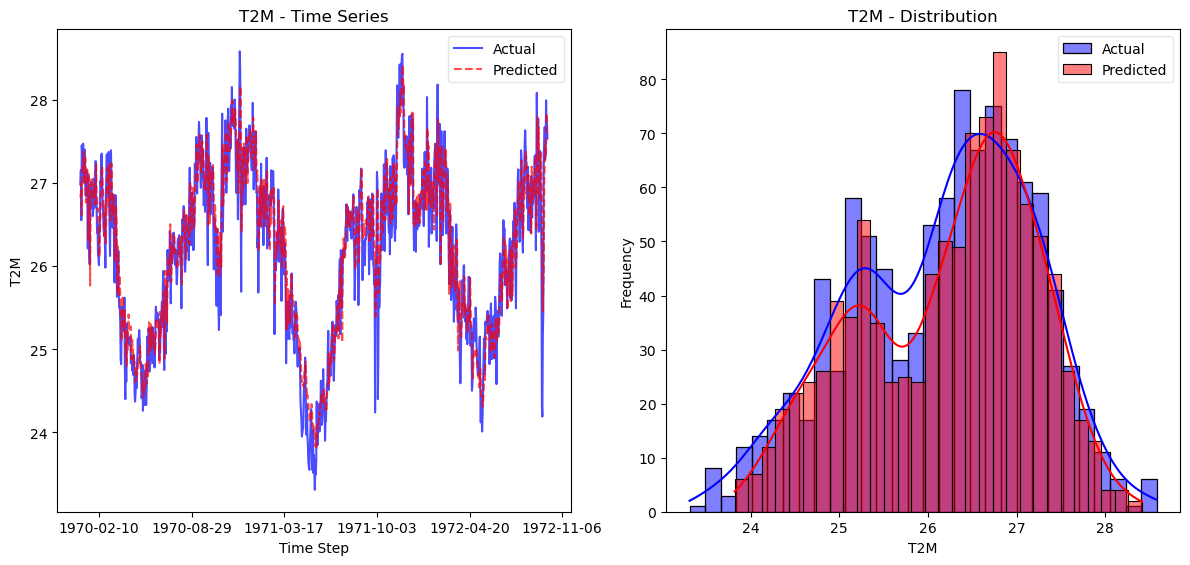

In [99]:
import matplotlib.dates as mdates
y_true_list=[]
y_pred_list=[]
model_name="TKAN"
col=0
metrics_list=[]

var_name,city="T2M","Abidjan"
fig, axes = plt.subplots( 1,2, figsize=(12, 6))
dates=date_test[14:]
with torch.no_grad():
    for X_batch, y_batch in Abj_test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).squeeze()
        outputs,_ = model(X_batch)
        outputs=outputs[:, -1,:].reshape(-1, 1)
        y_true_list.append(y_batch.cpu().numpy())
        y_pred_list.append(outputs.cpu().numpy())

    # Convert lists to NumPy arrays
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    # print(y_true .shape, y_pred.shape)
    # Inverse transform
    dummy_features = np.zeros((y_true.shape[0], X_batch.shape[2]-1 ))
    actuals_padded = np.hstack([dummy_features, y_true.reshape(-1, 1)])
    predictions_padded = np.hstack([dummy_features, y_pred.reshape(-1, 1)])
    # print("actuals_padded shape:",actuals_padded.shape, "Xbatch shape:", X_batch.shape,"predictions_padded shape:",predictions_padded.shape)
    actuals_ = scaler[col].inverse_transform(actuals_padded)[:, -1] # unscaled output result 
    predictions_ = scaler[col].inverse_transform(predictions_padded)[:, -1] # unscaled prediction result 
    # print( predictions_ [:10],actuals_ [:10]) 
    # Compute metrics
    mse_ = np.mean((actuals_ - predictions_) ** 2)
    rmse_ = np.sqrt(mse_)
    mae_ = np.mean(np.abs(actuals_ - predictions_))
    r2_ = 1 - (np.sum((actuals_ - predictions_) ** 2) / np.sum((actuals_ - np.mean(actuals_)) ** 2))

    mask = actuals_ != 0
    mape_ = np.mean(np.abs((actuals_[mask] - predictions_[mask]) / actuals_[mask])* 100) if mask.any() else np.nan

    # Store metrics
    metrics_list.append({
        "City": city,
        "Model": "TKAN",
        "Variable": var_name,
        "MSE": round(mse_,4),
        "RMSE": round(rmse_,4),
        "MAE": round(mae_,4),
        "R²": round(r2_,4),
        "MAPE": round(mape_,4)
    })
    # --- Subplot 1: Line Plot ---
    # dates=
    axes[0].plot(dates, actuals_, label="Actual", color="blue", alpha=0.7)
    axes[0].plot(dates, predictions_, label="Predicted", color="red", linestyle="dashed", alpha=0.7)
    axes[0].set_title(f"{var_name} - Time Series")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel(var_name)
    axes[0].legend(framealpha=0.5)
    axes[0].xaxis.set_major_locator(mdates.DayLocator(interval=200))  # Show every 7th day
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))  # Format: YYYY-MM-DD
    # plt.yscale('log')
    # axes[ 0].tick_params(axis="x", rotation=45)  # ✅ Correct


    # --- Subplot 2: Histogram ---
    sns.histplot(actuals_, label="Actual", color="blue", kde=True, bins=30, alpha=0.5, ax=axes[1])
    sns.histplot(predictions_, label="Predicted", color="red", kde=True, bins=30, alpha=0.5, ax=axes[1])
    axes[1].set_title(f"{var_name} - Distribution")
    axes[1].set_xlabel(var_name)
    axes[1].set_ylabel("Frequency")
    axes[1].legend(framealpha=0.5)
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle

plt.savefig(f"{city}_{var_name}_{model_name}.png")
plt.show()
    # print(idx_d)
# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_list)

In [96]:
metrics_df

,City,Model,Variable,MSE,RMSE,MAE,R²,MAPE
0,Abidjan,TKAN,PS,0.0101,0.1005,0.0857,0.5933,0.0853
